## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from scripts_step_lr_schedulers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
# Unzip files
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_1.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_2.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_3.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_4.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean/fold_5.tar.gz

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-5fold-roberta-64-clean/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
print(f'Training set samples: {len(k_fold)}')
display(k_fold.head())

Training set samples: 26882


,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,train,train,validation,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,validation,train,False


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 64,
  'BATCH_SIZE': 32,
  'EPOCHS': 7,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 2,
  'N_FOLDS': 5,
  'question_size': 4,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 1e-07 to 2.96e-05 to 1e-06


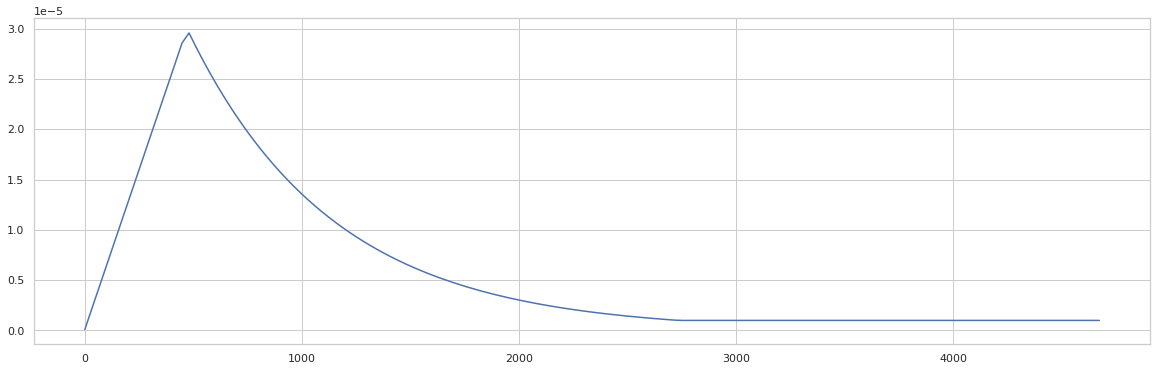

In [6]:
lr_min = 1e-6
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
warmup_steps = total_steps * 0.1
decay = .9985

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
from tensorflow.keras import backend

def Custom_loss(label_smoothing=0., weight=0.):
    def custom_loss(y_true, y_pred):
        cce = losses.CategoricalCrossentropy(label_smoothing=label_smoothing)
        y_true_pos = backend.cast(tf.math.argmax(y_true, axis=-1), 'float32')
        y_pred_pos = backend.cast(tf.math.argmax(y_pred, axis=-1), 'float32')

        loss = cce(y_true, y_pred)
        gap = tf.math.reduce_mean(tf.math.sqrt(tf.math.pow(tf.math.subtract(y_true_pos, y_pred_pos), 2)))
        gap = tf.math.multiply(gap, weight)
        loss = tf.math.add(loss, gap)

        return loss
    return custom_loss

In [8]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = layers.Dropout(.1)(last_hidden_state)
    
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(x)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(x)
    end_logits = layers.Flatten()(end_logits)

    start_probs = layers.Activation('softmax', name='y_start')(start_logits)
    end_probs = layers.Activation('softmax', name='y_end')(end_logits)

    model = Model(inputs=[input_ids, attention_mask], outputs=[start_probs, end_probs])
    
    return model

# Train

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=warmup_steps, lr_start=lr_start, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    
    model.compile(optimizer, loss={'y_start': Custom_loss(label_smoothing=0.2, weight=0.5),
                                   'y_end': Custom_loss(label_smoothing=0.2, weight=0.5)})
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=False, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)

    # Make predictions (best model)
#     model.load_weights(model_path)
    predict_eval_df(k_fold_best, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])
    
    ### Delete data dir
    shutil.rmtree(base_data_path)


FOLD: 1
Train for 672 steps, validate for 168 steps
Epoch 1/7
672/672 - 192s - loss: 8.7504 - y_start_loss: 4.2161 - y_end_loss: 4.5343 - val_loss: 5.6388 - val_y_start_loss: 2.8214 - val_y_end_loss: 2.8174
Epoch 2/7
672/672 - 178s - loss: 5.5712 - y_start_loss: 2.7372 - y_end_loss: 2.8340 - val_loss: 5.5121 - val_y_start_loss: 2.7407 - val_y_end_loss: 2.7713
Epoch 3/7
672/672 - 176s - loss: 5.2969 - y_start_loss: 2.6132 - y_end_loss: 2.6838 - val_loss: 5.5217 - val_y_start_loss: 2.7713 - val_y_end_loss: 2.7504
Epoch 4/7
Restoring model weights from the end of the best epoch.
672/672 - 176s - loss: 5.1484 - y_start_loss: 2.5455 - y_end_loss: 2.6029 - val_loss: 5.5180 - val_y_start_loss: 2.7650 - val_y_end_loss: 2.7530
Epoch 00004: early stopping

FOLD: 2
Train for 672 steps, validate for 168 steps
Epoch 1/7
672/672 - 191s - loss: 8.0809 - y_start_loss: 3.9585 - y_end_loss: 4.1224 - val_loss: 5.8183 - val_y_start_loss: 2.7799 - val_y_end_loss: 3.0384
Epoch 2/7
672/672 - 178s - loss: 5.

# Model loss graph

Fold: 1


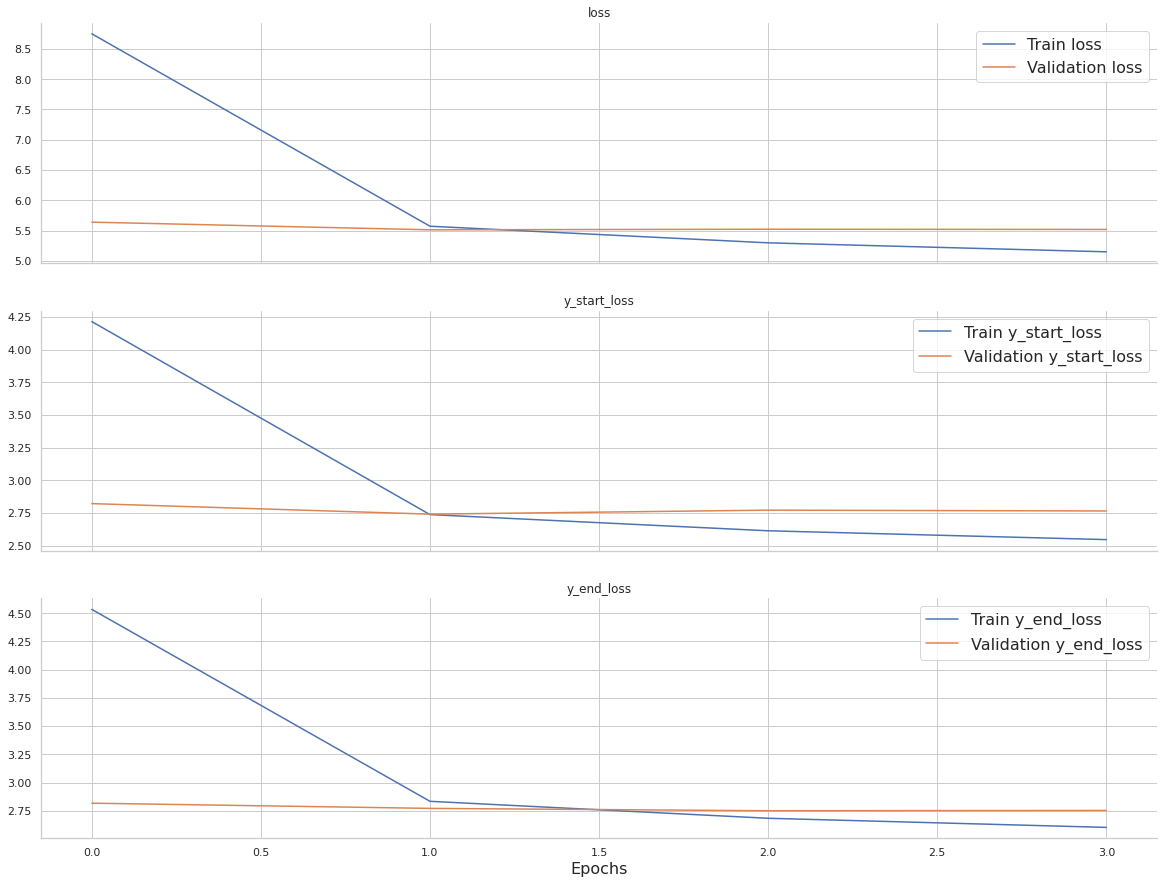

Fold: 2


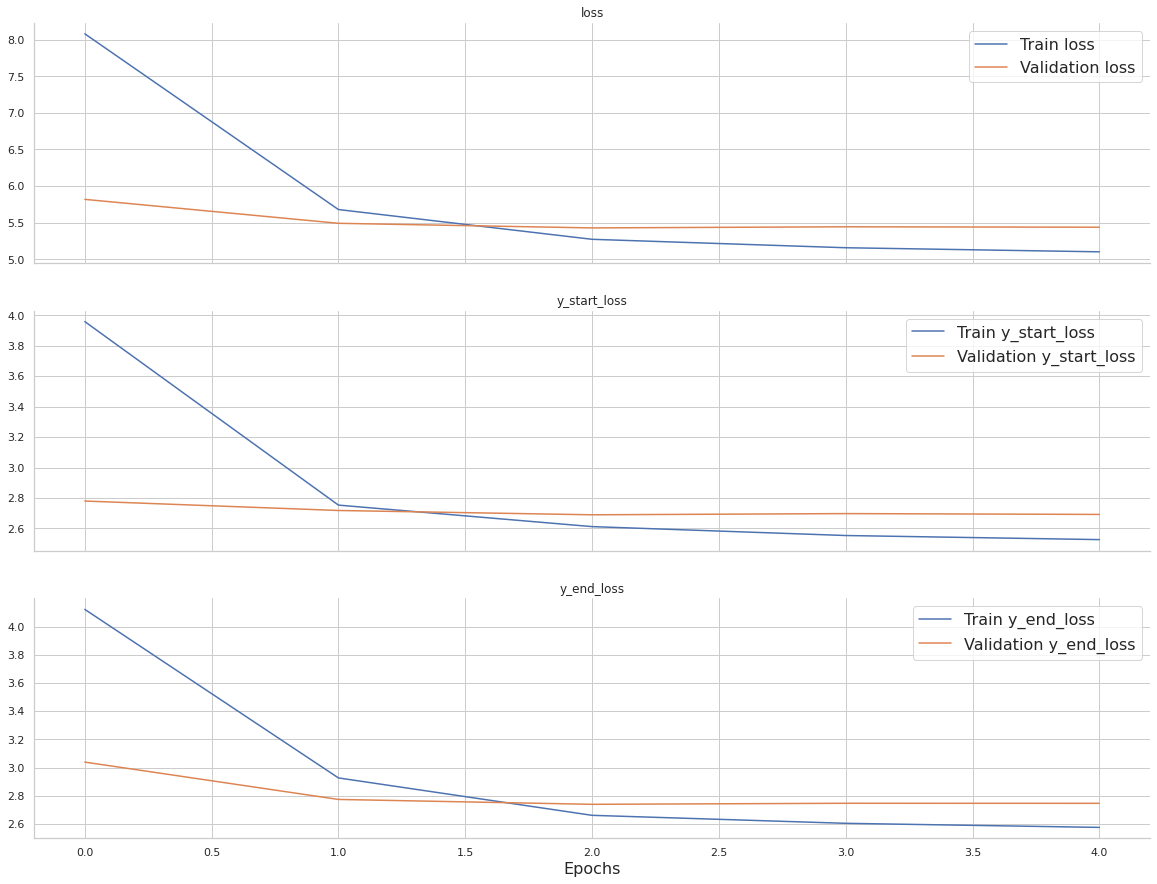

Fold: 3


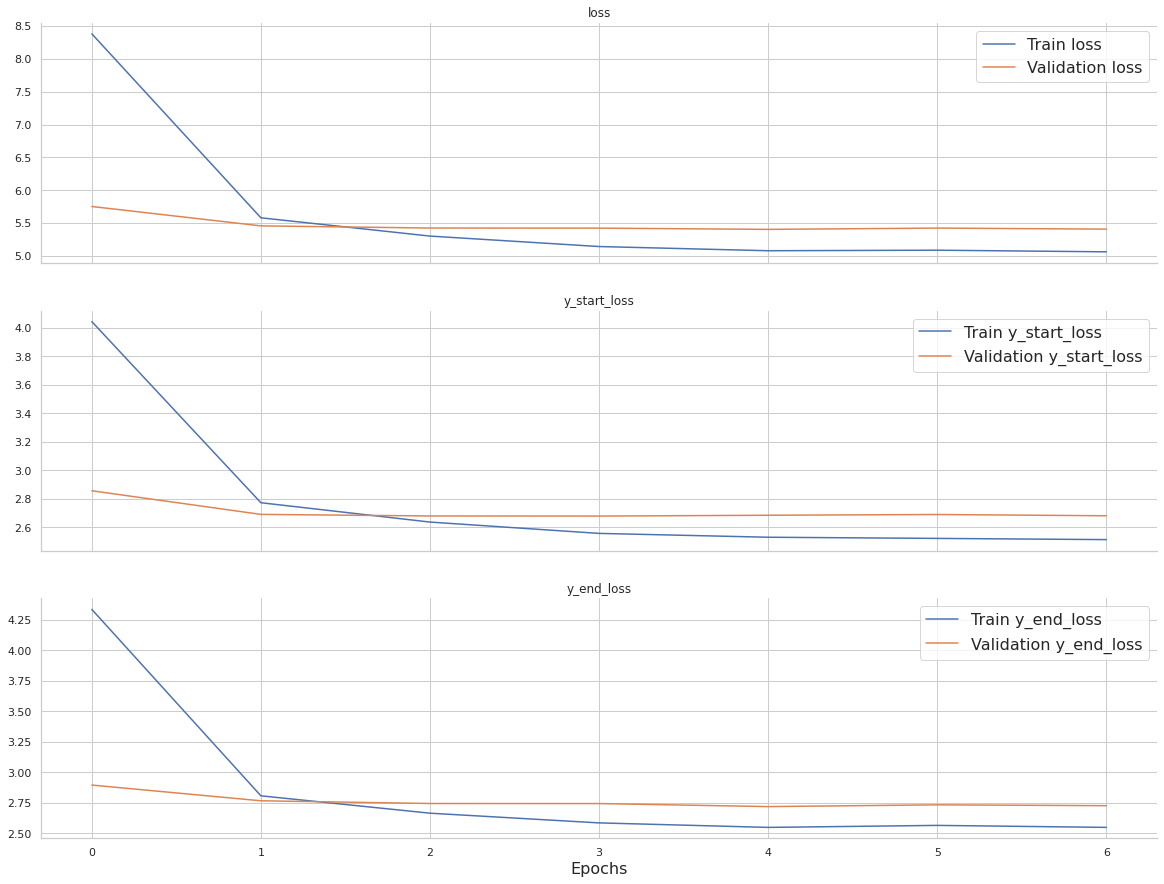

Fold: 4


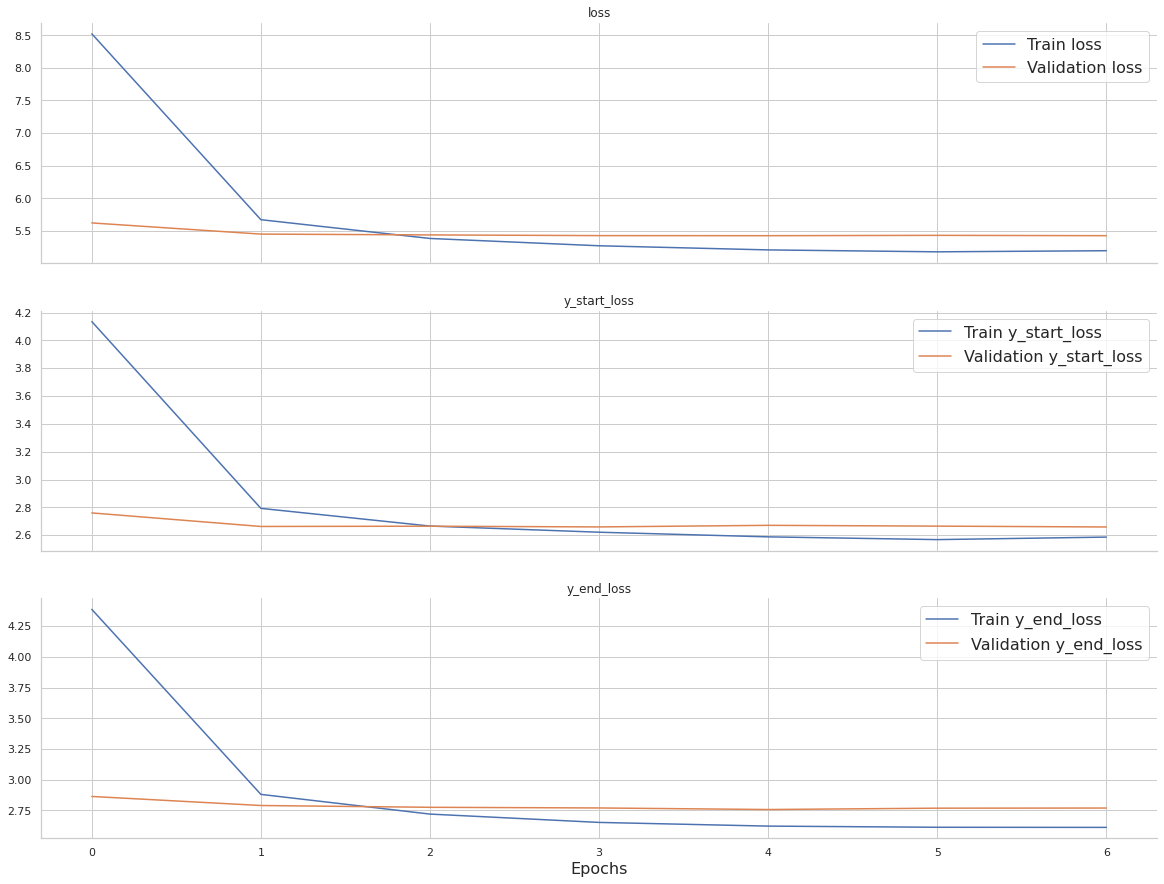

Fold: 5


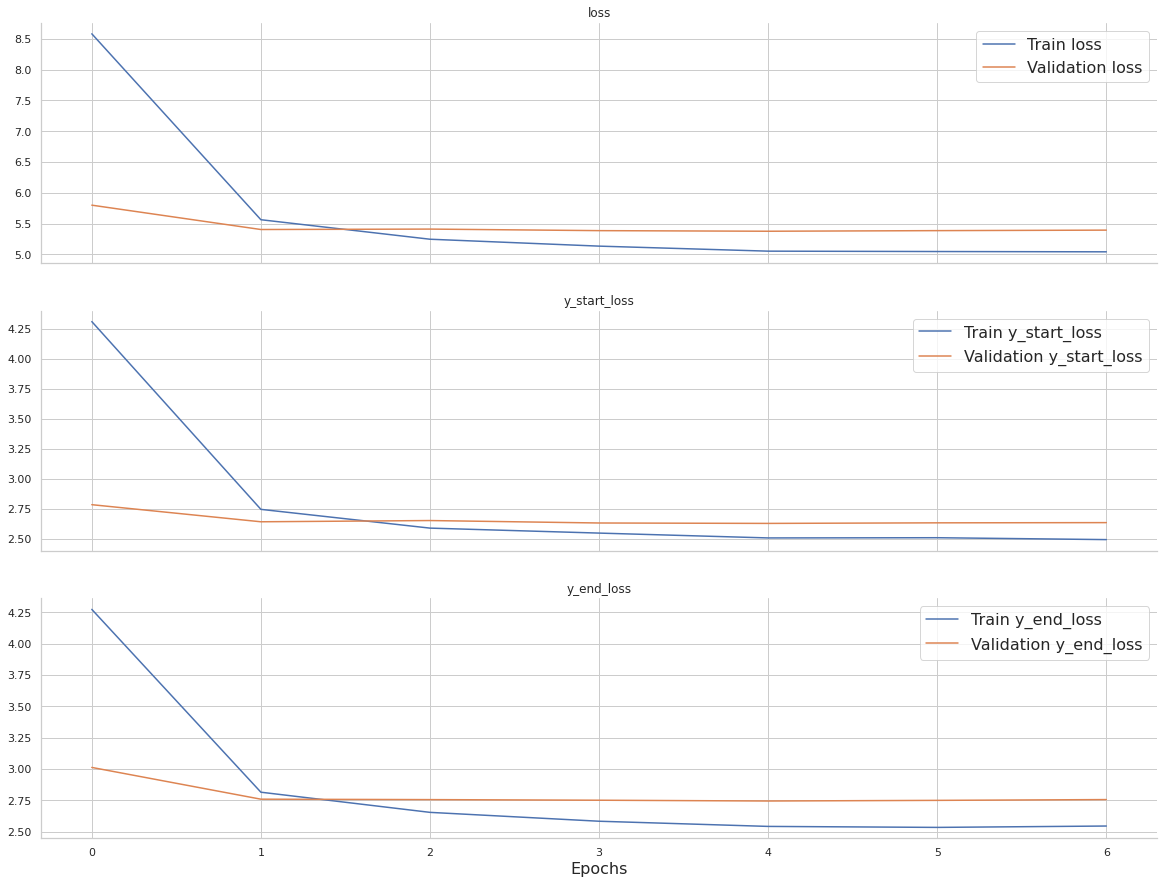

In [10]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (best model)

In [11]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.757340,0.725749,0.031592,0.745127,0.725182,0.752604,0.724169,0.765846,0.722841,0.755550,0.729091,0.767573,0.727460
Sentiment negative,0.608855,0.551532,0.057323,0.588912,0.553699,0.598463,0.547990,0.624891,0.558496,0.605394,0.552273,0.626616,0.545202
Sentiment neutral,0.978131,0.976724,0.001406,0.978183,0.976463,0.978104,0.977935,0.977656,0.975491,0.978410,0.975938,0.978302,0.977796
Sentiment positive,0.595804,0.547039,0.048764,0.574168,0.543503,0.589895,0.543408,0.609521,0.533007,0.592739,0.558330,0.612696,0.556948
0 <= text tokens < 3,0.959093,0.954937,0.004156,0.962222,0.959677,0.962719,0.932203,0.954741,0.963636,0.958333,0.957627,0.957447,0.961538
3 <= text tokens < 15,0.806646,0.782334,0.024312,0.797055,0.788890,0.801741,0.789373,0.814821,0.774862,0.805882,0.776825,0.813733,0.781721
15 <= text tokens < 30,0.727647,0.691266,0.036382,0.713920,0.689899,0.723336,0.677885,0.738042,0.688478,0.725336,0.696631,0.737603,0.703435
30 <= text tokens < 45,0.697335,0.657919,0.039417,0.681801,0.639360,0.692296,0.660796,0.702541,0.667488,0.693346,0.680999,0.716693,0.640952
45 <= text tokens < 120,0.820949,0.781697,0.039252,0.793475,0.865476,0.841559,0.794736,0.848321,0.589695,0.814470,0.851697,0.806918,0.806880


# Model evaluation (last model)

In [12]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

KeyError: 'prediction_fold_1'

# Visualize predictions

In [13]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,imputed
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,False
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,False
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,False
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,False
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,False
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,False
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,False
7,soooo high,soooo high,neutral,1.000000,3,3,False
8,both of you,both of you,neutral,1.000000,3,3,False
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,False
